### This notebook demonstrates the LeNet model.


First we load some dependencies for our code.

In [1]:
import numpy

import theano
import theano.tensor as T
theano.config.floatX = 'float32'

Let us first define the output layer, used for prediction, which is similar to the logistic regression that we have just seen

In [2]:
class LogisticRegression(object):
    """Multi-class Logistic Regression Class"""

    def __init__(self, input, n_in, n_out):
        # initialize with 0 the weights W as a matrix of shape (n_in, n_out)
        self.W = theano.shared(
            value=numpy.zeros(
                (n_in, n_out),
                dtype=theano.config.floatX),
            name='W',
            borrow=True)
        # initialize the biases b as a vector of n_out 0s
        self.b = theano.shared(
            value=numpy.zeros(
                (n_out,),
                dtype=theano.config.floatX),
            name='b',
            borrow=True)

        # symbolic expression for computing the matrix of class-membership
        # probabilities
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)

        # symbolic description of how to compute prediction as class whose
        # probability is maximal
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)

        # parameters of the model
        self.params = [self.W, self.b]

    def negative_log_likelihood(self, y):
        """Return the mean of the negative log-likelihood of the prediction
        of this model under a given target distribution.
        """
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])

    def errors(self, y):
        """Return a float representing the number of errors in the minibatch
        over the total number of examples of the minibatch ; zero one
        loss over the size of the minibatch
        """

        # check if y has same dimension of y_pred
        if y.ndim != self.y_pred.ndim:
            raise TypeError(
                'y should have the same shape as self.y_pred',
                ('y', y.type, 'y_pred', self.y_pred.type)
            )
        # check if y is of the correct datatype
        if y.dtype.startswith('int'):
            # the T.neq operator returns a vector of 0s and 1s, where 1
            # represents a mistake in prediction
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()

Now we can start to define the actual convolution code.  We start by defining an object that represents a single layer of convolution that does the actual convolution operation followed by pooling over the output of that convolution.  These layers will be stacked in the final model.

In [3]:
from theano.tensor.signal import pool
from theano.tensor.nnet import conv2d

class LeNetConvPoolLayer(object):
    def __init__(self, rng, input, filter_shape, image_shape, poolsize=(2, 2)):
        assert image_shape[1] == filter_shape[1]
        self.input = input

        # there are "num input feature maps * filter height * filter width"
        # inputs to each hidden unit
        fan_in = numpy.prod(filter_shape[1:])
        # each unit in the lower layer receives a gradient from:
        # "num output feature maps * filter height * filter width" / pooling size
        fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]) /
                   numpy.prod(poolsize))
        # initialize weights with random weights
        W_bound = numpy.sqrt(6. / (fan_in + fan_out))
        self.W = theano.shared(
            numpy.asarray(
                rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
                dtype=theano.config.floatX
            ),
            borrow=True
        )

        # the bias is a 1D tensor -- one bias per output feature map
        b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, borrow=True)

        # convolve input feature maps with filters
        conv_out = conv2d(
            input=input,
            filters=self.W,
            filter_shape=filter_shape,
            input_shape=image_shape
        )

        # pool each feature map individually, using maxpooling
        pooled_out = pool.pool_2d(
            input=conv_out,
            ds=poolsize,
            ignore_border=True
        )

        # add the bias term. Since the bias is a vector (1D array), we first
        # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
        # thus be broadcasted across mini-batches and feature map
        # width & height
        self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))

        # store parameters of this layer
        self.params = [self.W, self.b]

Let us also define a fully-connected layer

In [4]:
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh):
        self.input = input

        if W is None:
            W_values = numpy.asarray(
                rng.uniform(
                    low=-numpy.sqrt(6. / (n_in + n_out)),
                    high=numpy.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]

This next method uses the convolution layer above to make a stack of them and adds a hidden layer followed by a logistic regression classification layer on top.

In [5]:
import time

theano.config.floatX = 'float32'


def evaluate_lenet5(train_set, test_set, valid_set,
                    learning_rate=0.1, n_epochs=200,
                    nkerns=[20, 50], batch_size=500):
    rng = numpy.random.RandomState(23455)

    # create a python generator that returns minibatches one at a time
    def minibatch_generator(dataset):
        dataset_x, dataset_y = dataset
        for i in range(dataset_x.shape[0] // batch_size):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            batch_x = dataset_x[start_idx:end_idx]
            batch_y = dataset_y[start_idx:end_idx]
            yield (batch_x, batch_y)

    x = T.matrix('x')
    y = T.lvector('y')

    # Construct the first convolutional pooling layer:
    # filtering reduces the image size to (28-5+1 , 28-5+1) = (24, 24)
    # maxpooling reduces this further to (24/2, 24/2) = (12, 12)
    # 4D output tensor is thus of shape (batch_size, nkerns[0], 12, 12)
    layer0 = LeNetConvPoolLayer(
        rng,
        input=x.reshape((batch_size, 1, 28, 28)),
        image_shape=(batch_size, 1, 28, 28),
        filter_shape=(nkerns[0], 1, 5, 5),
        poolsize=(2, 2)
    )

    # Construct the second convolutional pooling layer
    # filtering reduces the image size to (12-5+1, 12-5+1) = (8, 8)
    # maxpooling reduces this further to (8/2, 8/2) = (4, 4)
    # 4D output tensor is thus of shape (batch_size, nkerns[1], 4, 4)
    layer1 = LeNetConvPoolLayer(
        rng,
        input=layer0.output,
        image_shape=(batch_size, nkerns[0], 12, 12),
        filter_shape=(nkerns[1], nkerns[0], 5, 5),
        poolsize=(2, 2)
    )

    # the HiddenLayer being fully-connected, it operates on 2D matrices of
    # shape (batch_size, num_pixels) (i.e matrix of rasterized images).
    # This will generate a matrix of shape (batch_size, nkerns[1] * 4 * 4),
    # or (500, 50 * 4 * 4) = (500, 800) with the default values.
    layer2_input = layer1.output.flatten(2)

    # construct a fully-connected sigmoidal layer
    layer2 = HiddenLayer(
        rng,
        input=layer2_input,
        n_in=nkerns[1] * 4 * 4,
        n_out=500,
        activation=T.tanh
    )

    # classify the values of the fully-connected sigmoidal layer
    layer3 = LogisticRegression(input=layer2.output, n_in=500, n_out=10)

    # the cost we minimize during training is the NLL of the model
    cost = layer3.negative_log_likelihood(y)

    # create a function to compute the mistakes that are made by the model
    model_errors = theano.function(
        [x, y],
        layer3.errors(y)
    )

    # create a list of all model parameters to be fit by gradient descent
    params = layer3.params + layer2.params + layer1.params + layer0.params

    # create a list of gradients for all model parameters
    grads = T.grad(cost, params)

    # train_model is a function that updates the model parameters by
    # SGD Since this model has many parameters, it would be tedious to
    # manually create an update rule for each model parameter. We thus
    # create the updates list by automatically looping over all
    # (params[i], grads[i]) pairs.
    updates = [
        (param_i, param_i - learning_rate * grad_i)
        for param_i, grad_i in zip(params, grads)
    ]

    train_model = theano.function(
        [x, y],
        cost,
        updates=updates
    )

    # early-stopping parameters
    patience = 10000  # look as this many examples regardless
    patience_increase = 2  # wait this much longer when a new best is found

    # a relative improvement of this much is considered significant
    improvement_threshold = 0.995

    n_train_batches = (train_set[0].shape[0] + batch_size - 1) // batch_size
    
    # go through this many minibatches before checking the network on
    # the validation set; in this case we check every epoch
    validation_frequency = min(n_train_batches, patience / 2)

    best_validation_loss = numpy.inf
    best_iter = 0
    test_score = 0.
    start_time = time.clock()

    epoch = 0
    iter = 0
    done_looping = False

    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1

        minibatch_index = 0
        for minibatch in minibatch_generator(train_set):
            iter += 1
            minibatch_index += 1
            if iter % 100 == 0:
                print('training @ iter = %i' % iter)

            error = train_model(minibatch[0], minibatch[1])

            if (iter + 1) % validation_frequency == 0:

                # compute zero-one loss on validation set
                validation_losses = [model_errors(vb[0], vb[1]) for vb
                                     in minibatch_generator(valid_set)]
                this_validation_loss = numpy.mean(validation_losses)
                print('epoch %i, minibatch %i/%i, validation error %f %%' %
                      (epoch, minibatch_index + 1, n_train_batches,
                       this_validation_loss * 100.))

                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:

                    # improve patience if loss improvement is good enough
                    if this_validation_loss < best_validation_loss * improvement_threshold:
                        patience = max(patience, iter * patience_increase)

                    # save best validation score and iteration number
                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # test it on the test set
                    test_losses = [
                        model_errors(tb[0], tb[1])
                        for tb in minibatch_generator(test_set)
                    ]
                    test_score = numpy.mean(test_losses)
                    print(('     epoch %i, minibatch %i/%i, test error of '
                           'best model %f %%') %
                          (epoch, minibatch_index + 1, n_train_batches,
                           test_score * 100.))

            if patience <= iter:
                done_looping = True
                break

    end_time = time.clock()
    print('Optimization complete.')
    print('Best validation score of %f %% obtained at iteration %i, '
          'with test performance %f %%' %
          (best_validation_loss * 100., best_iter + 1, test_score * 100.))
    print('The code ran for %.2fm' % ((end_time - start_time) / 60.))

    # This is to make the pretty pictures in the cells below
    layer0_out = theano.function([x], layer0.output)
    layer1_out = theano.function([x], layer1.output)
    
    return params, layer0_out, layer1_out

This cell runs the model and allows you to play with a few hyperparameters.  The ones below take about 1 to 2 minutes to run.

## Load the data
This will load a pre-packaged version of MNIST, each split as NumPy ndarrays.

In [6]:
import gzip
import six
from six.moves import cPickle

with gzip.open('../data/mnist.pkl.gz', 'rb') as data_file:
    if six.PY3:
        train_set, valid_set, test_set = cPickle.load(data_file, encoding='latin1')
    else:
        train_set, valid_set, test_set = cPickle.load(data_file)

In [7]:
params, layer0_out, layer1_out = evaluate_lenet5(train_set, test_set, valid_set,
                                                 learning_rate=0.1, n_epochs=5,
                                                 nkerns=[10, 25], batch_size=50)

training @ iter = 100
training @ iter = 200
training @ iter = 300
training @ iter = 400
training @ iter = 500
training @ iter = 600
training @ iter = 700
training @ iter = 800
training @ iter = 900
epoch 1, minibatch 1000/1000, validation error 2.540000 %
     epoch 1, minibatch 1000/1000, test error of best model 2.770000 %
training @ iter = 1000
training @ iter = 1100
training @ iter = 1200
training @ iter = 1300
training @ iter = 1400
training @ iter = 1500
training @ iter = 1600
training @ iter = 1700
training @ iter = 1800
training @ iter = 1900
epoch 2, minibatch 1000/1000, validation error 1.900000 %
     epoch 2, minibatch 1000/1000, test error of best model 1.890000 %
training @ iter = 2000
training @ iter = 2100
training @ iter = 2200
training @ iter = 2300
training @ iter = 2400
training @ iter = 2500
training @ iter = 2600
training @ iter = 2700
training @ iter = 2800
training @ iter = 2900
epoch 3, minibatch 1000/1000, validation error 1.500000 %
     epoch 3, minibatch 10

For most convolution model it can be interesting to show what the trained filters look like.  The code below does that from the parameters returned by the training function above.  In this model there isn't much of an effect since the filters are 5x5 and we can't see much unfortunately.

(-0.5, 148.5, 58.5, -0.5)

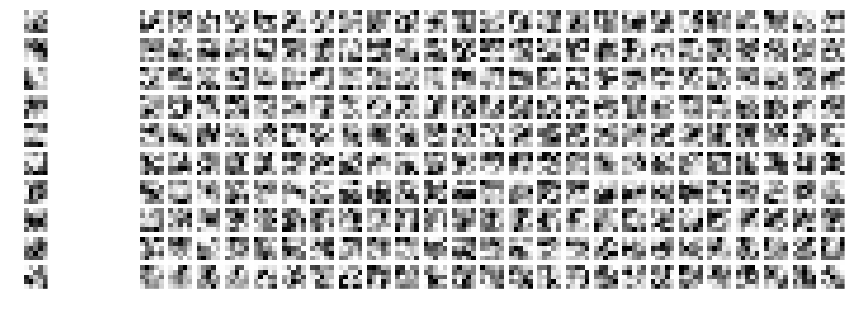

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

from utils import tile_raster_images

filts1 = params[6].get_value()
filts2 = params[4].get_value()

plt.clf()

# Increase the size of the figure
plt.gcf().set_size_inches(15, 10)

# Make a grid for the two layers
gs = plt.GridSpec(1, 2, width_ratios=[1, 25], height_ratios=[1, 1])
a = plt.subplot(gs[0])
b = plt.subplot(gs[1])


# Show the first layer filters (the small column)
a.imshow(tile_raster_images(filts1.reshape(10, 25), img_shape=(5, 5), tile_shape=(10, 1), tile_spacing=(1,1)),
           cmap="Greys", interpolation="none")
a.axis('off')

# Show the second layer filters (the large block)
b.imshow(tile_raster_images(filts2.reshape(250, 25), img_shape=(5, 5), tile_shape=(10, 25), tile_spacing=(1,1)),
           cmap="Greys", interpolation="none")
b.axis('off')


What can also be interesting is to draw the outputs of the filters for an example.  This works somewhat better for this model.

(-0.5, 23.5, 23.5, -0.5)

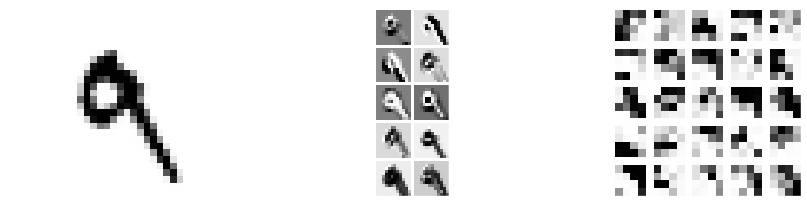

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

from utils import tile_raster_images

# Grab some input examples from the test set (we cheat a bit here)
sample = test_set[0][:50]
# We will print this example amongst the batch
example = 7

plt.gcf()

# Increase the size of the figure
plt.gcf().set_size_inches(15, 10)

gs = plt.GridSpec(1, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

# Draw the input data
a = plt.subplot(gs[0])
a.imshow(sample[example].reshape(28, 28), cmap="Greys", interpolation='none')
a.axis('off')

# Compute first layer output
out0 = layer0_out(sample)[example]

# Draw its output
b = plt.subplot(gs[1])
b.imshow(tile_raster_images(out0.reshape(10, 144), img_shape=(12, 12), tile_shape=(5, 2), tile_spacing=(1, 1)),
         cmap="Greys", interpolation='none')
b.axis('off')

# Compute the second layer output
out1 = layer1_out(sample)[example]

# Draw it
c = plt.subplot(gs[2])
c.imshow(tile_raster_images(out1.reshape(25, 16), img_shape=(4, 4), tile_shape=(5, 5), tile_spacing=(1, 1)),
         cmap="Greys", interpolation='none')
c.axis('off')

Some things you can try with this model:
- change the non linearity of the convolution to rectifier unit.
- add an extra mlp layer.

If you break the code too much you can always get back to the working initial code by doing `git checkout -- convnet/lenet.ipynb` from the command line.